In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_PLATFORMS"] = "cpu" # only use CPU in this notebook

In [6]:
import jax
import jax.numpy as jnp

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [7]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [8]:
jax.devices()

[CpuDevice(id=0)]

# Runtime NUTS

## Runtime and efficiency (benchmark 1)

In [5]:
"""Same noise realization, multiple chains; different starting positions from some ball."""
path = "/pscratch/sd/i/imendoza/data/cache_chains/results_benchmark1_20240918061901.npy"

d1 = jnp.load(path, allow_pickle=True)[()]

In [6]:
d1.keys()
ALL_N_CHAINS = list(d1.keys())
ALL_N_CHAINS

[1, 5, 10, 25, 50, 100, 150, 200]

In [7]:
# extract samples for easy use
samples = {n:d1[n]['states'].position for n in ALL_N_CHAINS}
samples[100]['f'].shape

(100, 1000)

In [8]:
N_SAMPLES = samples[100]['f'].shape[-1]
N_SAMPLES

1000

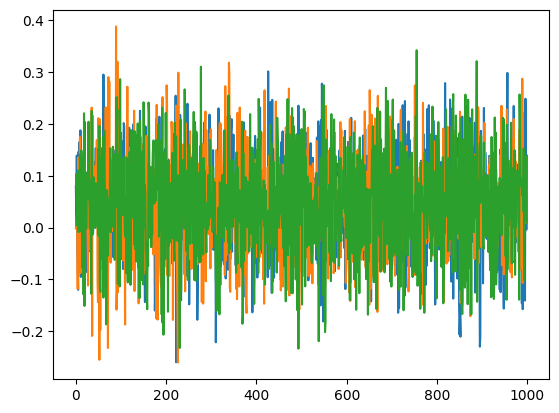

In [9]:
# examples
p = 'g1'
plt.plot(samples[100][p][0,:])
plt.plot(samples[100][p][2,:])
plt.plot(samples[100][p][11,:])

Text(0, 0.5, 'avg. time to process 1 image as a function of samples (s)')

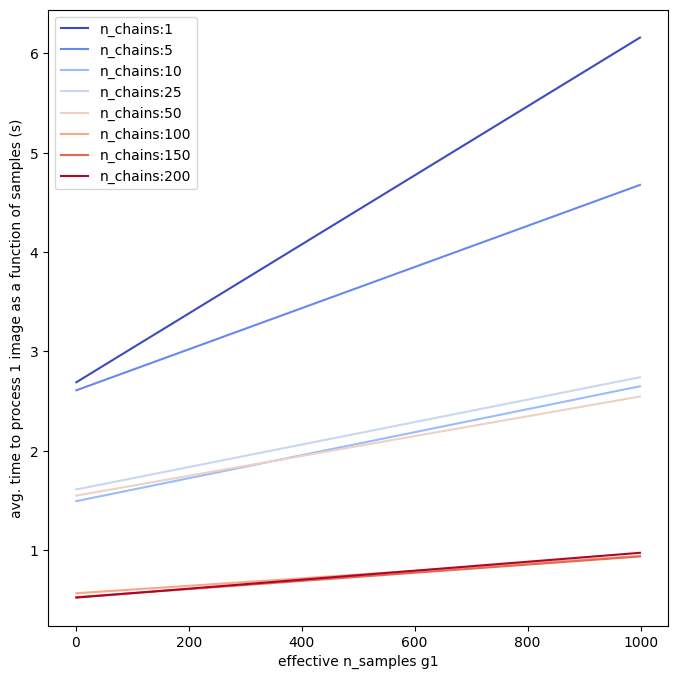

In [11]:
# time per obj. as a function of EFFECTIVE n_samples 
# different chains

import cycler

n = len(ALL_N_CHAINS)
color = plt.cm.coolwarm(np.linspace(0, 1, n))
cycles = cycler.cycler('color', color)

# time per sample per object
plt.figure(figsize=(8, 8))
plt.gca().set_prop_cycle(cycles)


n_samples_arr = np.arange(1, 1000, 1)
p = 'g1'

times1 = [] 
times2 = []
for n in ALL_N_CHAINS: 
    _ns = samples[n][p].size
    ns = jnp.clip(effective_sample_size(samples[n][p], chain_axis=0, sample_axis=1), min=0, max=_ns)# total effective samples
    warmup_time_per_obj = d1[n]['warmup_run_time']  / n
    sampling_time_per_sample_per_obj = d1[n]['inference_run_time'] / ns 
    times1.append(warmup_time_per_obj)
    times2.append(sampling_time_per_sample_per_obj)
    
    
for ii, n in enumerate(ALL_N_CHAINS):
    wt = times1[ii]
    rt = times2[ii]
    tt = wt + rt * n_samples_arr # per obj
    plt.plot(n_samples_arr, tt, label=f'n_chains:{n}')

# plt.yscale("log")
plt.legend()

plt.xlabel(f"effective n_samples {p}")
plt.ylabel("avg. time to process 1 image as a function of samples (s)")


## Runtime and efficiency (benchmark 2

In [9]:
"""Multiple noise realization, multiple chains; different starting positions from some ball."""
path = "/pscratch/sd/i/imendoza/data/cache_chains/results_benchmark2_20240918063640.npy"

d2 = jnp.load(path, allow_pickle=True)[()]

In [10]:
d2.keys()
ALL_N_CHAINS = list(d2.keys())
ALL_N_CHAINS

[4, 20, 40, 100, 200]

In [11]:
# extract samples for easy use
samples = {n:d2[n]['states'].position for n in ALL_N_CHAINS}
samples[100]['f'].shape

(25, 4, 1000)

In [12]:
N_SAMPLES = samples[100]['f'].shape[-1]
N_SAMPLES

1000

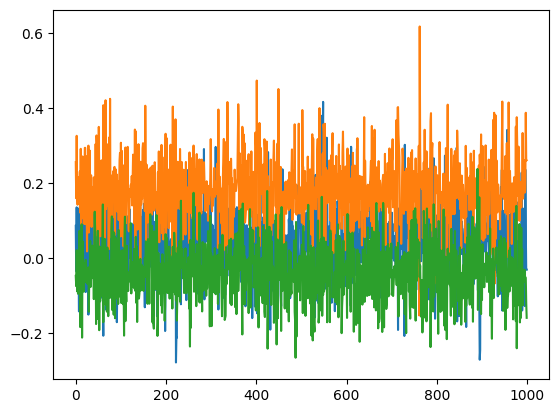

In [13]:
# examples
p = 'g1'
plt.plot(samples[100][p][0, 0, :])
plt.plot(samples[100][p][1, 1, :])
plt.plot(samples[100][p][10, 3, :])

Text(0, 0.5, 'avg. time to process 1 image as a function of samples (s)')

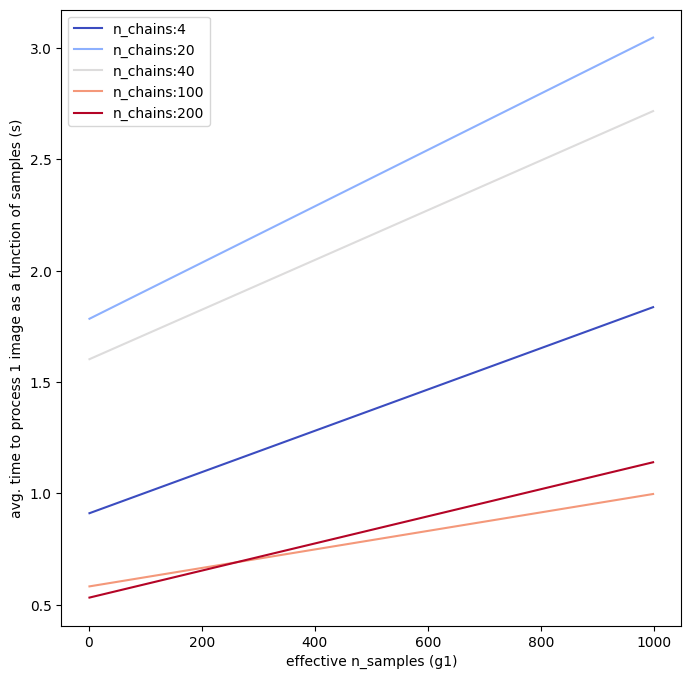

In [14]:
# time per obj. as a function of EFFECTIVE n_samples 
# different chains

import cycler

n = len(ALL_N_CHAINS)
color = plt.cm.coolwarm(np.linspace(0, 1, n))
cycles = cycler.cycler('color', color)

# time per sample per object
plt.figure(figsize=(8, 8))
plt.gca().set_prop_cycle(cycles)


n_samples_arr = np.arange(1, 1000, 1)
p = 'g1'

times1 = [] 
times2 = []
for n in ALL_N_CHAINS: 
    _ns = samples[n][p].size # total samples across all objects and chains
    
    # effective samples summed over each noise realization
    # clip effective samples to total samples
    ns = sum([
        jnp.clip(effective_sample_size(samples[n][p][ii], chain_axis=0, sample_axis=1)
                 ,min=0, max=4*1000) 
        for ii in range(n//4)])
    warmup_time_per_obj = d2[n]['warmup_run_time']  / n
    sampling_time_per_sample_per_obj = d2[n]['inference_run_time'] / ns 
    times1.append(warmup_time_per_obj)
    times2.append(sampling_time_per_sample_per_obj)
    
    
for ii, n in enumerate(ALL_N_CHAINS):
    wt = times1[ii]
    rt = times2[ii]
    tt = wt + rt * n_samples_arr # per obj
    plt.plot(n_samples_arr, tt, label=f'n_chains:{n}')

# plt.yscale("log")
plt.legend()

plt.xlabel(f"effective n_samples ({p})")
plt.ylabel("avg. time to process 1 image as a function of samples (s)")


In [15]:
# check r-hats
p = 'g1'
for n in ALL_N_CHAINS:
    print(n)
    r_hats = []
    for ii in range(n//4):
        r1 = potential_scale_reduction(samples[n][p][ii], chain_axis=0, sample_axis=1)
        r_hats.append(r1.item())
    print(r_hats)
    print()

4
[0.9999366402626038]

20
[1.0001392364501953, 0.9995766282081604, 0.9997978806495667, 1.0000306367874146, 0.9997952580451965]

40
[0.9998501539230347, 1.000002145767212, 0.9997043609619141, 0.9995481371879578, 1.0001760721206665, 0.9995831847190857, 0.9999081492424011, 0.9998689293861389, 1.000001072883606, 0.9998044967651367]

100
[1.000084638595581, 0.9999876022338867, 0.9996063709259033, 0.9996321797370911, 1.0006206035614014, 0.9998754858970642, 0.9999660849571228, 0.9997773766517639, 0.9999502897262573, 1.0006747245788574, 0.9996557235717773, 0.9998334050178528, 0.9998903870582581, 0.9998071193695068, 1.000063419342041, 0.9996305704116821, 1.0005978345870972, 1.0005779266357422, 0.9998483061790466, 1.0017921924591064, 0.9999783039093018, 0.9999837279319763, 1.0000673532485962, 1.0009422302246094, 0.9997029900550842]

200
[1.0001734495162964, 0.9998201727867126, 0.9996546506881714, 1.000054955482483, 0.9996850490570068, 0.9997143149375916, 0.9995381832122803, 0.9996123313903809, 

In [20]:
# total divergences
n_divs = d2[200]['info'].is_divergent.sum()
n_steps = d2[200]['info'].is_divergent.size
n_divs, n_divs / n_steps 


(Array(329, dtype=int32), Array(0.001645, dtype=float32))

(array([ 1.,  1.,  0.,  0.,  0.,  1.,  4.,  7., 12., 17., 22., 23., 30.,
        18., 22., 15., 12.,  5.,  6.,  2.,  2.]),
 array([0.32848504, 0.34825188, 0.36801875, 0.38778558, 0.40755242,
        0.42731926, 0.44708613, 0.46685296, 0.4866198 , 0.50638664,
        0.5261535 , 0.54592037, 0.56568718, 0.58545405, 0.60522091,
        0.62498772, 0.64475459, 0.6645214 , 0.68428826, 0.70405513,
        0.72382194, 0.74358881]),
 [<matplotlib.patches.Polygon at 0x7f6fa02f57b0>])

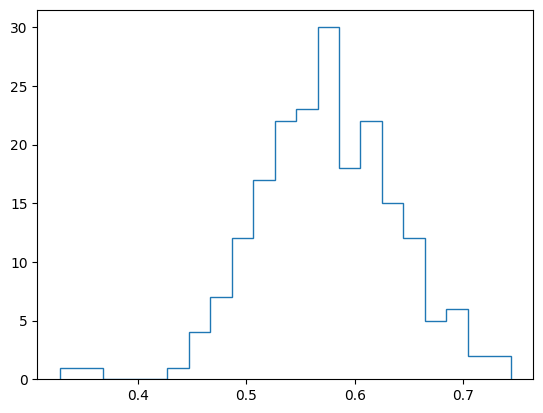

In [24]:
# how different are tuned step sizes for different noise realizations of sample galaxy
step_size = d2[200]['tuned_params']['step_size']
ss = step_size.ravel()
plt.hist(ss, bins=21, histtype='step')

In [25]:
d2[200]['tuned_params']['inverse_mass_matrix'].shape

(50, 4, 6, 6)

In [28]:
d2[200]['states'].position.keys() # order for imm

dict_keys(['f', 'g1', 'g2', 'hlr', 'x', 'y'])

(array([ 5.,  3., 10.,  9., 12., 18., 20., 15., 19., 21., 20., 11.,  8.,
         9.,  6.,  5.,  4.,  2.,  1.,  0.,  2.]),
 array([0.06741545, 0.07384411, 0.08027276, 0.08670142, 0.09313007,
        0.09955873, 0.10598738, 0.11241604, 0.11884469, 0.12527335,
        0.13170199, 0.13813065, 0.14455931, 0.15098795, 0.15741661,
        0.16384527, 0.17027393, 0.17670257, 0.18313123, 0.18955989,
        0.19598854, 0.20241719]),
 [<matplotlib.patches.Polygon at 0x7f6f607967a0>])

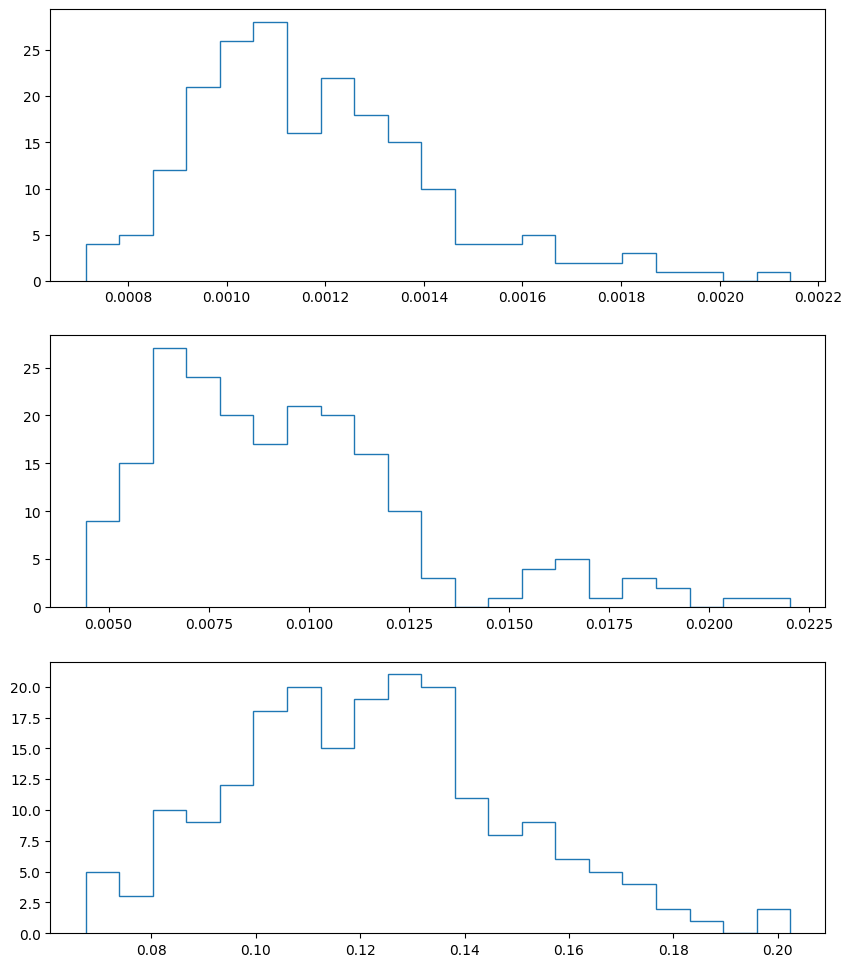

In [33]:
imm = d2[200]['tuned_params']['inverse_mass_matrix'].reshape(-1, 6, 6)
diags = [] 
for ii in range(6):
    diags.append(imm[:, ii, ii])
diags = jnp.array(diags)

figs, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

ax1.hist(diags[0], bins=21, histtype='step') #  f
ax2.hist(diags[1], bins=21, histtype='step') # g1
ax3.hist(diags[4], bins=21, histtype='step') # x

## Chees (benchmark1 )

In [34]:
"""Multiple noise realization, multiple chains; different starting positions from some ball."""
path = "/pscratch/sd/i/imendoza/data/cache_chains/results_chees_benchmark1_20240918102022.npy"

d3 = jnp.load(path, allow_pickle=True)[()]

In [36]:
ALL_N_CHAINS = (1, 5, 10, 25, 50, 100, 150, 200, 300, 500)
d3.keys()

dict_keys([1, 5, 10, 25, 50, 100, 150, 200, 300, 500, 'inference_comp_time', 'data', 'init_positions'])

In [42]:
d3[100]['states'].position['f'].shape

(100, 1000)

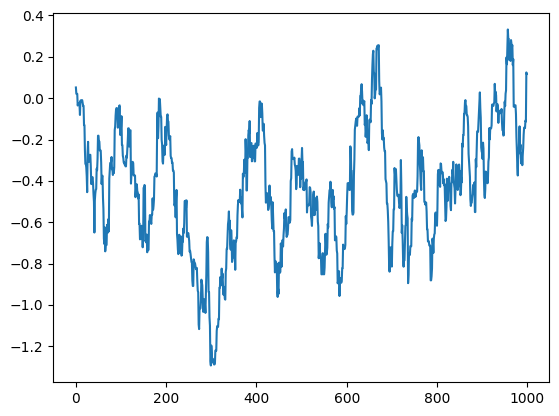

In [45]:
plt.plot(d3[100]['states'].position['x'][0])

In [46]:
effective_sample_size(d3[100]['states'].position['x'], chain_axis=0, sample_axis=1)

Array(849.0598, dtype=float32)

In [50]:
potential_scale_reduction(d3[100]['states'].position['x'], chain_axis=0, sample_axis=1)

Array(1.0483389, dtype=float32)

In [51]:
d3[100]['warmup_run_time'] / 100 + d3[100]['inference_run_time'] / 100

0.2296351647377014

In [38]:
for n_chains in ALL_N_CHAINS:
    print(n_chains)
    print(d3[n_chains]['warmup_run_time'] + d3[n_chains]['inference_run_time'])
    print('total n samples:', d3[n_chains]['states'].position['f'].size)
    print()
                                                    

1
7.322470426559448
total n samples: 1000

5
10.151132106781006
total n samples: 5000

10
10.543315172195435
total n samples: 10000

25
19.589933156967163
total n samples: 25000

50
30.322444915771484
total n samples: 50000

100
22.96351647377014
total n samples: 100000

150
29.034861087799072
total n samples: 150000

200
36.05764722824097
total n samples: 200000

300
48.40626120567322
total n samples: 300000

500
72.64298582077026
total n samples: 500000



# Max doublings = 1

In [61]:

path = "/pscratch/sd/i/imendoza/data/cache_chains/results_benchmark-v2_7_100_42_md=0.npy" # 10 chains, 42 seed

d1 = jnp.load(path, allow_pickle=True)[()]

In [62]:
d1['warmup_run_time'], d1['inference_run_time']

(2.115990400314331, 4.129770040512085)

In [63]:
d1['states'].position['f'].shape

(100, 1000)

In [64]:
path = "/pscratch/sd/i/imendoza/data/cache_chains/results_benchmark-v2_7_1000_42_md=1.npy" # 10 chains, 42 seed
d2 = jnp.load(path, allow_pickle=True)[()]

In [65]:
d2['warmup_run_time'], d2['inference_run_time']

(16.80199885368347, 33.30547022819519)

In [66]:
d2['states'].position['f'].shape

(1000, 1000)

In [67]:

path = "/pscratch/sd/i/imendoza/data/cache_chains/results_benchmark-v2_8_100_42_md=1.npy" # 10 chains, 42 seed

d3 = jnp.load(path, allow_pickle=True)[()]

In [68]:
d1['warmup_run_time'], d1['inference_run_time']

(2.115990400314331, 4.129770040512085)

In [69]:
d1['states'].position['f'].shape

(100, 1000)

In [70]:
from blackjax.diagnostics import effective_sample_size
effective_sample_size(d1['states'].position['g1'], chain_axis=0, sample_axis=1)

2024-09-10 09:34:15.469681: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array(99.83785, dtype=float32)